<a href="https://colab.research.google.com/github/alabiyusuf/clustering_assessment/blob/main/MLDM_Clustering_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Machine Learning Data Mining Project: Customer Personality Analysis**

Source of Dataset:
https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis

Goal: This project is designed to help retail businesses effectively target their marketing campaigns by identifying customer groups most likely to respond positively to new offers or promotions.

I will apply unsupervised learning (clustering) to discover distinct customer segments based on:
- Demographic factors (age, education, marital status, household size, income)
- Behavioural / transactional factors (spend on different product categories, channel usage, recency, tenure)
- Derived features relevant for marketing, such as customer tenure and family composition.

These clusters will then be profiled and linked back to historical campaign response, so the business can
decide *which* segment is most promising for future campaigns.

### **Importing Libraries**

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# sklearn modules for preprocessing, clustering, dimensionality reduction and evaluation

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage

from collections import Counter

In [10]:
from google.colab import output

output.eval_js('''
var style = document.createElement('style');
style.innerHTML = `
  .code-cell {
      background-color: #f5f5f5 !important;
      border-left: 3px solid #4b8bf4 !important;
      padding-left: 10px !important;
  }
  .output {
      background-color: white !important;
      border-left: none !important;
  }
  .output pre {
      background-color: white !important;
  }
`;
document.head.appendChild(style);
''', ignore_result=True)

In [11]:
# Loading the dataset from Google Drive.]
from google.colab import drive
drive.mount('/content/drive')

# The dataset uses tab ('\t') as the delimiter instead of a comma, hence the
# reason why I am specifying it to correctly split the columns when reading the
# file.

# Loading the customer dataset from the CSV file and then creating a working
# copy of the dataframe so that the original dataset copy is preserved
customer_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine-Learning/Assessment-Task-2/marketing_campaign.csv', sep='\t')
data = customer_data.copy()


print("Columns in raw dataset:\n", data.columns)
print("\nShape of raw dataset (rows, columns):", data.shape)

Mounted at /content/drive
Columns in raw dataset:
 Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

Shape of raw dataset (rows, columns): (2240, 29)


**Observation:** There are 2240 instances and 29 features in the raw dataset.

In [12]:
# Display first and last 10 rows in the dataset.

display(data.head(10))
display(data.tail(10))

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
5,7446,1967,Master,Together,62513.0,0,1,09-09-2013,16,520,...,6,0,0,0,0,0,0,3,11,0
6,965,1971,Graduation,Divorced,55635.0,0,1,13-11-2012,34,235,...,6,0,0,0,0,0,0,3,11,0
7,6177,1985,PhD,Married,33454.0,1,0,08-05-2013,32,76,...,8,0,0,0,0,0,0,3,11,0
8,4855,1974,PhD,Together,30351.0,1,0,06-06-2013,19,14,...,9,0,0,0,0,0,0,3,11,1
9,5899,1950,PhD,Together,5648.0,1,1,13-03-2014,68,28,...,20,1,0,0,0,0,0,3,11,0


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
2230,7004,1984,Graduation,Single,11012.0,1,0,16-03-2013,82,24,...,9,1,0,0,0,0,0,3,11,0
2231,9817,1970,Master,Single,44802.0,0,0,21-08-2012,71,853,...,8,0,0,0,0,0,0,3,11,0
2232,8080,1986,Graduation,Single,26816.0,0,0,17-08-2012,50,5,...,4,0,0,0,0,0,0,3,11,0
2233,9432,1977,Graduation,Together,666666.0,1,0,02-06-2013,23,9,...,6,0,0,0,0,0,0,3,11,0
2234,8372,1974,Graduation,Married,34421.0,1,0,01-07-2013,81,3,...,7,0,0,0,0,0,0,3,11,0
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0
2239,9405,1954,PhD,Married,52869.0,1,1,15-10-2012,40,84,...,7,0,0,0,0,0,0,3,11,1


**Observation**: The top and bottom rows confirm a consistent structure:
- Demographics (Age represented via Year_Birth, Education, Marital_Status)
- Income and household composition
- Tenure represented via Dt_Customer
- Purchasing behaviour by product category and channel
- Marketing-related flags (AcceptedCmp1-5, Response) and admin fields (Z_CostContact, Z_Revenue, Complain).

In [13]:
print("\n .info() on raw dataset ")
data.info()

display(data.describe().T)




 .info() on raw dataset 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurc

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2216.0,52247.251354,25173.076661,1730.0,35303.00,51381.5,68522.00,666666.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0


**Observation**:  
`.info()` and `.describe()` shows:
- numeric columns where expected,
- only one column (`Income`) with missing values,
- ranges that look sane (no negative spending, no insane ages yet).


### **Data Cleaning & Feature Engineering**

In [14]:
#  Year_Birth ----
# It’s easier for humans to reasonates with Age than Year_Birth.

data["Age"] = 2025 - data["Year_Birth"]

# Put Age where Year_Birth used to be, then drop Year_Birth

year_birth_index = data.columns.get_loc("Year_Birth")
data = data.drop("Year_Birth", axis=1)
data.insert(year_birth_index, "Age", data.pop("Age"))

print("Shape after creating Age and dropping Year_Birth:", data.shape)
display(data[["Age"]].head())

Shape after creating Age and dropping Year_Birth: (2240, 29)


,Age
0,68
1,71
2,60
3,41
4,44


**Observation**:  
Now I have a proper `Age` column and have removed `Year_Birth`.  
Age values look reasonable (mostly adults, some older customers), which will later help
interpret clusters like “younger online shoppers” vs “older loyal spenders”, etc.

**Outlier check for continuous variables**


 Basic outlier check (IQR-based, 25th–75th percentiles)
Age: IQR=18.00, suggested bounds ≈ [21.00, 93.00]


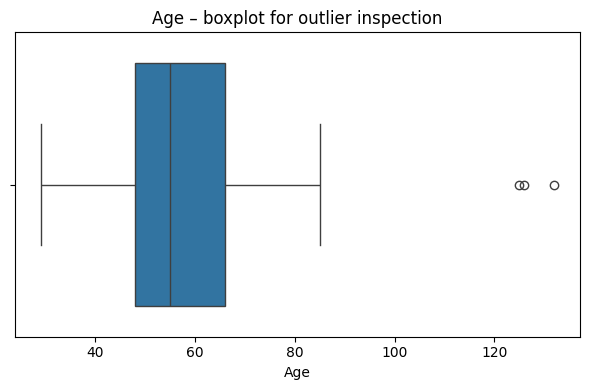

Income: IQR=33219.00, suggested bounds ≈ [-14525.50, 118350.50]


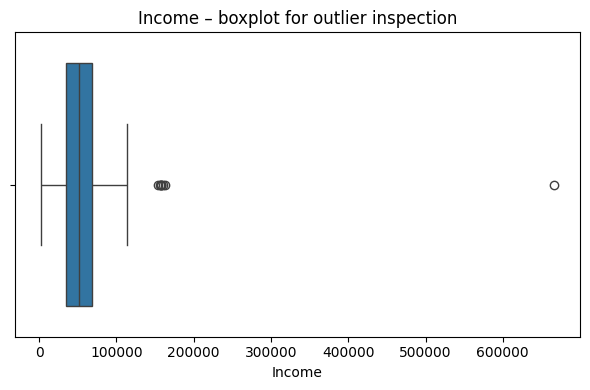

In [15]:
key_outlier_cols = ["Age", "Income"]

print("\n Basic outlier check (IQR-based, 25th–75th percentiles)")
for col in key_outlier_cols:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    print(f"{col}: IQR={iqr:.2f}, suggested bounds ≈ [{lower:.2f}, {upper:.2f}]")

    plt.figure(figsize=(6, 4))
    sns.boxplot(x=data[col])
    plt.title(f"{col} – boxplot for outlier inspection")
    plt.tight_layout()
    plt.show()

**Observation:** The IQR-based bounds for Age and Income suggest there are some high-income customers, but they are still within reasonable marketing ranges, so I keep them as valid high-value customers rather than removing them as outliers.

In [16]:
# Clean up Marital_Status

print("\nMarital_Status BEFORE cleaning:")
display(data["Marital_Status"].value_counts())

# Remove weird entries and merge "Together" into "Married"

data = data[~data["Marital_Status"].isin(["Alone", "Absurd", "YOLO"])]
data["Marital_Status"] = data["Marital_Status"].replace("Together", "Married")

print("\nMarital_Status after cleaning:")

display(data["Marital_Status"].value_counts())


Marital_Status BEFORE cleaning:


,count
Marital_Status,
Married,864
Together,580
Single,480
Divorced,232
Widow,77
Alone,3
Absurd,2
YOLO,2



Marital_Status after cleaning:


,count
Marital_Status,
Married,1444
Single,480
Divorced,232
Widow,77


**Observation**:  
I’ve removed obviously weird categories ('Alone', 'Absurd', 'YOLO') and merged 'Together'
into 'Married'. This makes the marital feature more realistic and easier to explain later.

In [17]:
# Clean up Education

print("\nEducation BEFORE cleaning:")
display(data["Education"].value_counts())

# Change '2n Cycle' entry into 'Master' (as it’s roughly equivalent)

data["Education"] = data["Education"].replace("2n Cycle", "Master")

print("\nEducation AFTER cleaning:")
display(data["Education"].value_counts())


Education BEFORE cleaning:


,count
Education,
Graduation,1125
PhD,483
Master,368
2n Cycle,203
Basic,54



Education AFTER cleaning:


,count
Education,
Graduation,1125
Master,571
PhD,483
Basic,54


**Observation**:  
Education now has a cleaner set of categories: Basic, Graduation, Master, PhD.
This avoids over-fragmenting the customer base on slightly different labels that mean almost the same thing.


In [18]:
# Tenure from Dt_Customer

# Dt_Customer = date of enrolment. I’ll convert to Tenure in days.

data.rename(columns={"Dt_Customer": "Enrollment_Date"}, inplace=True)

# In this dataset, dates are in DD-MM-YYYY format

data["Enrollment_Date"] = pd.to_datetime(data["Enrollment_Date"], dayfirst=True)

# Calculating each customers tenure, which is relative to their enrollment date
# or lifespan.

reference_date = pd.to_datetime("2025-11-10")
data["Tenure"] = (reference_date - data["Enrollment_Date"]).dt.days

display(data[["Enrollment_Date", "Tenure"]].head())


,Enrollment_Date,Tenure
0,2012-09-04,4815
1,2014-03-08,4265
2,2013-08-21,4464
3,2014-02-10,4291
4,2014-01-19,4313


**Observation**:  
Tenure (in days) gives me a simple “how long have they been a customer?” measure.
This is handy to distinguish brand-new vs long-term customers in the clustering.


### **Treating Missing Values**

In [19]:
print("\nMissing values per column before cleaning:")
display(data.isnull().sum())


Missing values per column before cleaning:


,0
ID,0
Age,0
Education,0
Marital_Status,0
Income,24
Kidhome,0
Teenhome,0
Enrollment_Date,0
Recency,0
MntWines,0


**Observation**:  
Only `Income` has missing values. Given Income is quite important for marketing segmentation, I’d rather drop those few rows than try to guess their income blindly.

In [20]:
# Drop rows with missing Income
data = data.dropna(subset=["Income"])

print("\nMissing values per column after dropping Income NaNs:")
display(data.isnull().sum())


Missing values per column after dropping Income NaNs:


,0
ID,0
Age,0
Education,0
Marital_Status,0
Income,0
Kidhome,0
Teenhome,0
Enrollment_Date,0
Recency,0
MntWines,0


**Observation**:  
All missing values in the `Income` column are gone.  
Everything else is complete. So from now on I’m working with a fully populated dataset.

### **Feature Explanaition**

I need to decide what to pass into the clustering algorithms.

Things I definitely want:

- Lifecycle / loyalty:
  - Age, Tenure

- Spending power & behaviour:
  - Income
  - MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds
  - Recency (how long since last purchase)

- Household composition:
  - Kidhome, Teenhome

- Channel usage:
  - NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth

- Demographic data:
  - Education, Marital_Status

Note:  
I will not include `AcceptedCmp1`–`AcceptedCmp5` or `Response` in the clustering features.
Those are campaign outcomes. I specifically want to:
1. Find natural customer segments,
2. Then check which segments have higher `Response` rates.

### **Exploratory Data Analysis and Correlation**

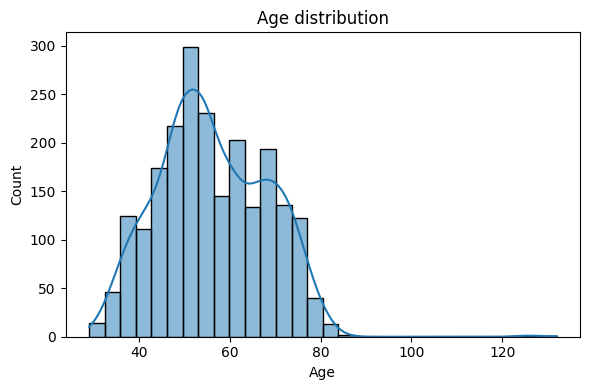

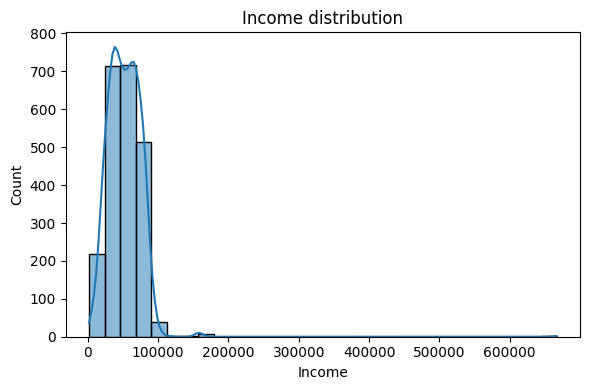

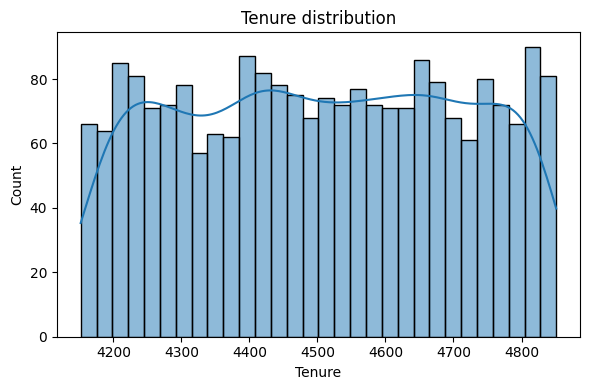

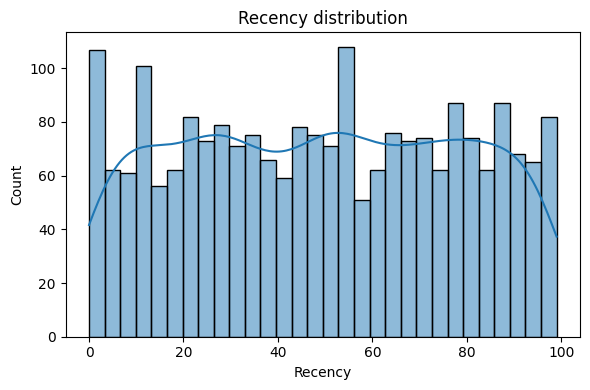

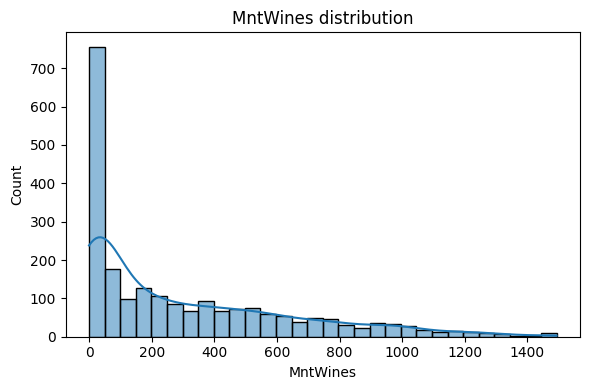

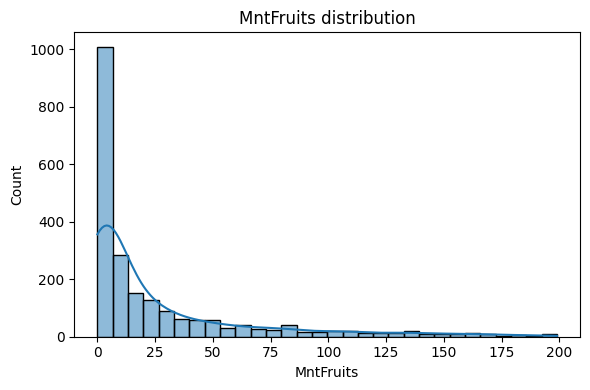

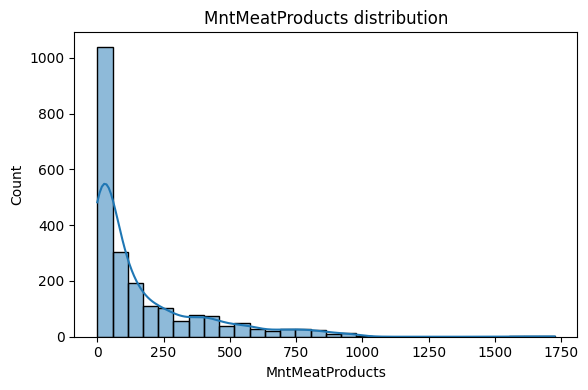

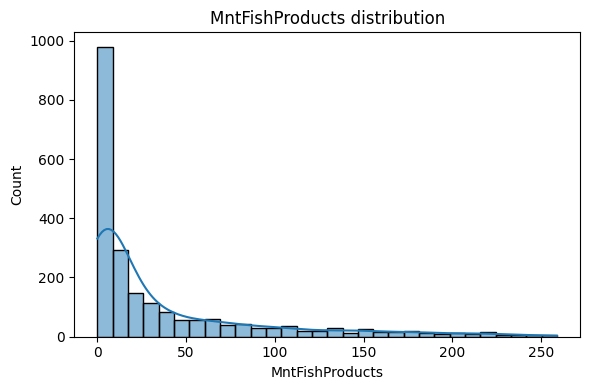

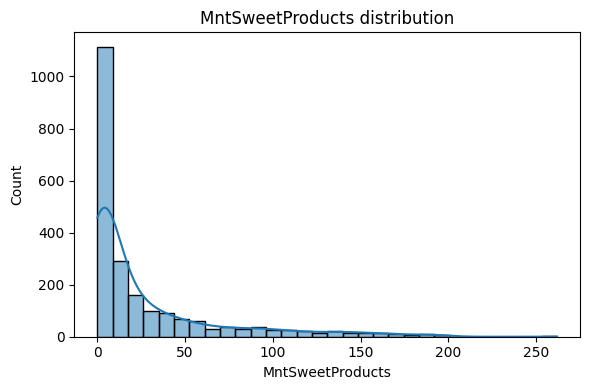

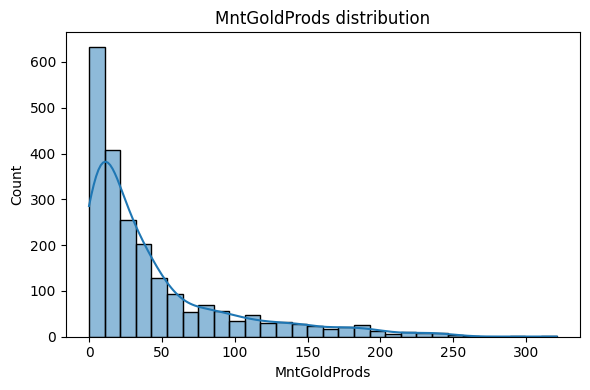

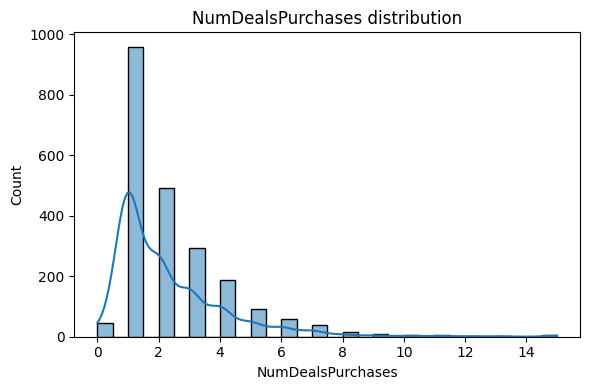

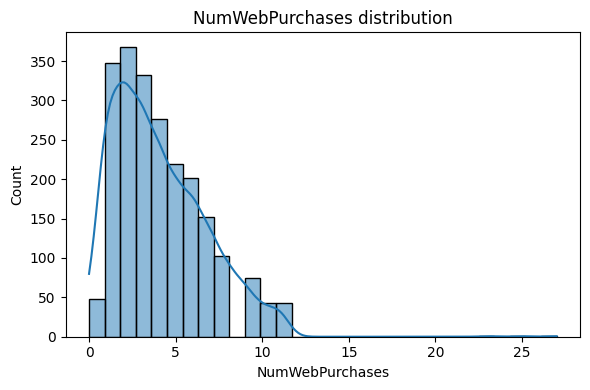

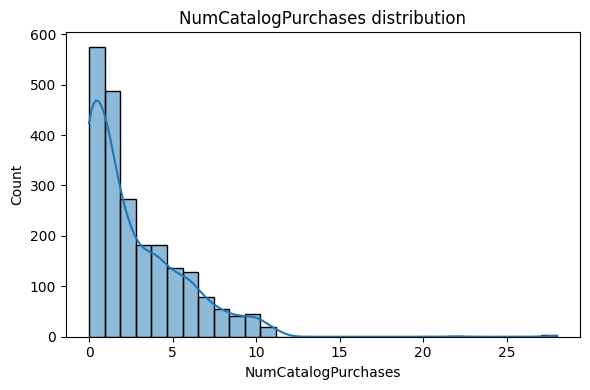

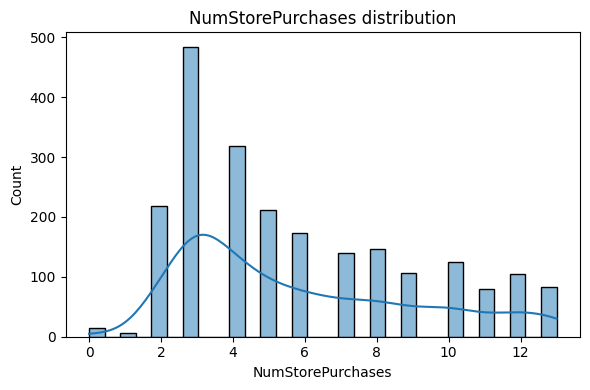

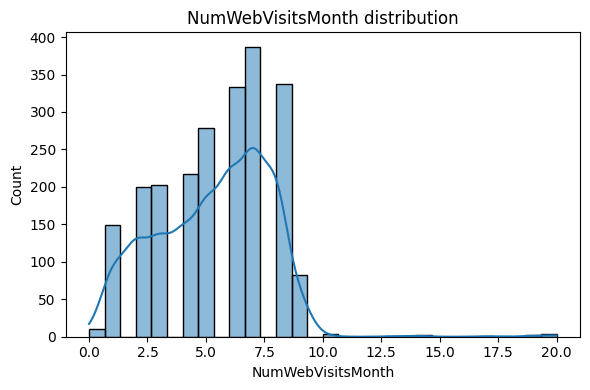

In [21]:
# Key columns I’ll be using for my clustering
continuous_cols = [
    "Age", "Income", "Tenure", "Recency",
    "MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts",
    "MntSweetProducts", "MntGoldProds", "NumDealsPurchases", "NumWebPurchases",
    "NumCatalogPurchases", "NumStorePurchases", "NumWebVisitsMonth"
]

# Histograms for continuous variables
for col in continuous_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f"{col} distribution")
    plt.tight_layout()
    plt.show()

**Observation:** Most numeric variables are right-skewed, meaning lots of low spenders / low interaction customers, and a smaller group of heavy users. That’s totally expected in retail datasets and another reason why scaling matters later on.

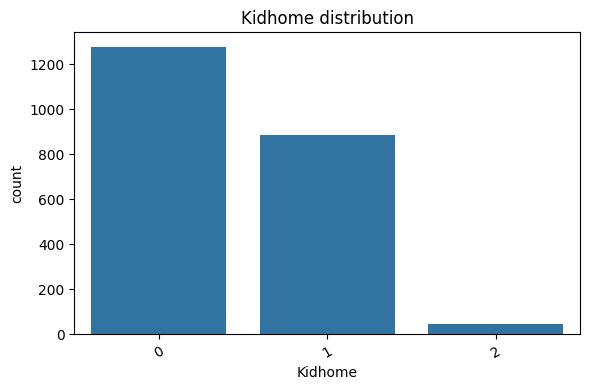

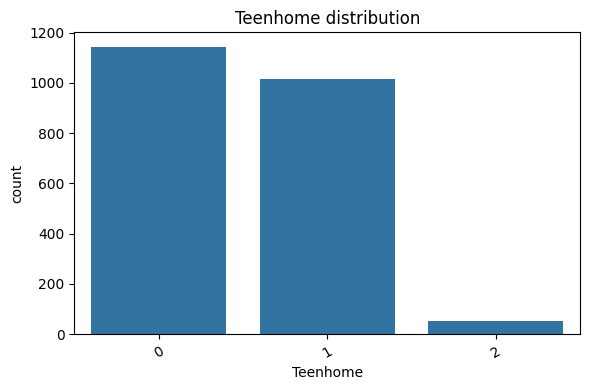

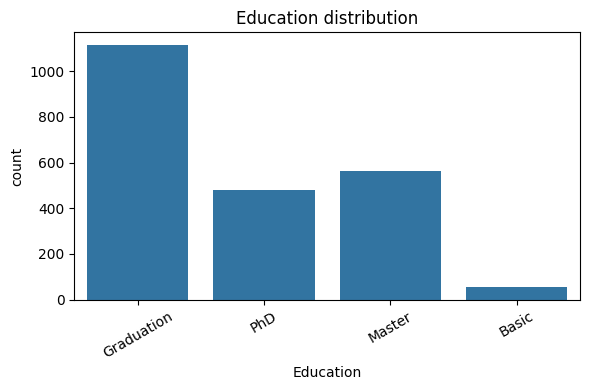

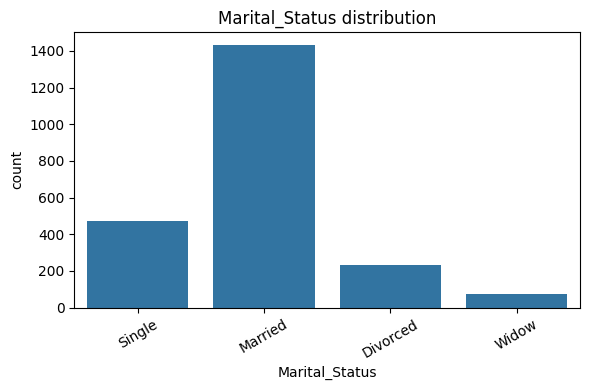

In [22]:
# Simple categorical EDA

categorical_cols = ["Kidhome", "Teenhome", "Education", "Marital_Status"]

for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=data)
    plt.title(f"{col} distribution")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


**Observation**:  
- Many customers have 0 or 1 child/teen at home.
- Education: Graduation dominates, with smaller Master/PhD groups.
- Marital_Status: mostly Married, then Single, then smaller groups.
These patterns will help name / describe clusters later.

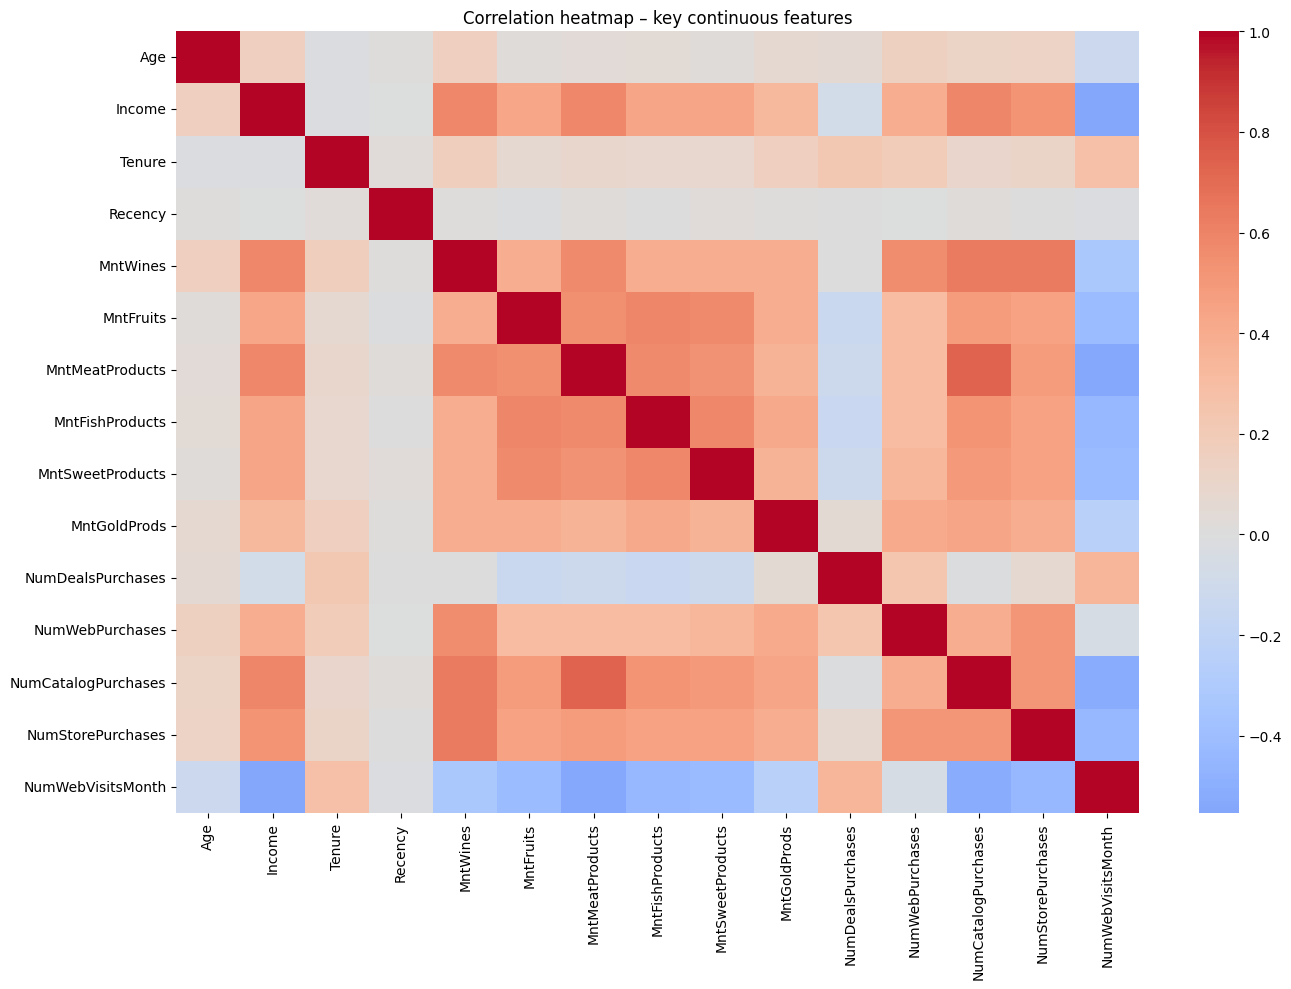

In [23]:
# Correlation heatmap for continuous features

plt.figure(figsize=(14, 10))
corr_matrix = data[continuous_cols].corr()
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation heatmap – key continuous features")
plt.tight_layout()
plt.show()

**Observation**:  
Some product spending variables (e.g. wines and meats) are positively correlated, which hints at an “overall high spender” dimension.  
PCA + scaling will help handle these correlations before clustering.


### **OneHotEncoding**

In [24]:

# Turn Education and Marital_Status into dummy variables

data = pd.get_dummies(
    data,
    columns=["Education", "Marital_Status"],
    drop_first=True
)

display(data.head())
print("\nDtypes after get_dummies:")
print(data.dtypes)

# Making sure no booleans are in the clustering features
for col in data.select_dtypes("bool").columns:
    data[col] = data[col].astype(int)

display(data.columns)

,ID,Age,Income,Kidhome,Teenhome,Enrollment_Date,Recency,MntWines,MntFruits,MntMeatProducts,...,Z_CostContact,Z_Revenue,Response,Tenure,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Married,Marital_Status_Single,Marital_Status_Widow
0,5524,68,58138.0,0,0,2012-09-04,58,635,88,546,...,3,11,1,4815,True,False,False,False,True,False
1,2174,71,46344.0,1,1,2014-03-08,38,11,1,6,...,3,11,0,4265,True,False,False,False,True,False
2,4141,60,71613.0,0,0,2013-08-21,26,426,49,127,...,3,11,0,4464,True,False,False,True,False,False
3,6182,41,26646.0,1,0,2014-02-10,26,11,4,20,...,3,11,0,4291,True,False,False,True,False,False
4,5324,44,58293.0,1,0,2014-01-19,94,173,43,118,...,3,11,0,4313,False,False,True,True,False,False



Dtypes after get_dummies:
ID                                 int64
Age                                int64
Income                           float64
Kidhome                            int64
Teenhome                           int64
Enrollment_Date           datetime64[ns]
Recency                            int64
MntWines                           int64
MntFruits                          int64
MntMeatProducts                    int64
MntFishProducts                    int64
MntSweetProducts                   int64
MntGoldProds                       int64
NumDealsPurchases                  int64
NumWebPurchases                    int64
NumCatalogPurchases                int64
NumStorePurchases                  int64
NumWebVisitsMonth                  int64
AcceptedCmp3                       int64
AcceptedCmp4                       int64
AcceptedCmp5                       int64
AcceptedCmp1                       int64
AcceptedCmp2                       int64
Complain                      

Index(['ID', 'Age', 'Income', 'Kidhome', 'Teenhome', 'Enrollment_Date',
       'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'Tenure',
       'Education_Graduation', 'Education_Master', 'Education_PhD',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Widow'],
      dtype='object')

**Observation**:  
`Education` and `Marital_Status` are now represented as 0/1 columns  
(e.g. Education_Master, Marital_Status_Single, etc.).  
This keeps the information but makes it numeric for the clustering algorithms.


### **Feature Selection for Clustering & Scaling**

In [25]:
# Explicit list of clustering features

features = [
    "Age", "Income", "Kidhome", "Teenhome", "Recency",
    "MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts",
    "MntSweetProducts", "MntGoldProds",
    "NumDealsPurchases", "NumWebPurchases", "NumCatalogPurchases",
    "NumStorePurchases", "NumWebVisitsMonth", "Tenure",
    "Education_Graduation", "Education_Master", "Education_PhD",
    "Marital_Status_Married", "Marital_Status_Single", "Marital_Status_Widow"
]

X = data[features].copy()

# Convert any remaining booleans to ints
for col in X.select_dtypes(include=["bool"]).columns:
    X[col] = X[col].astype(int)

print("Final feature set used for clustering (X):")
print(list(X.columns))
print("\nShape of X:", X.shape)


Final feature set used for clustering (X):
['Age', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Tenure', 'Education_Graduation', 'Education_Master', 'Education_PhD', 'Marital_Status_Married', 'Marital_Status_Single', 'Marital_Status_Widow']

Shape of X: (2209, 23)


**Observation**:  
All features in `X` are numeric and business-meaningful.  
No campaign outcome variables are in there, which keeps the clustering genuinely unsupervised.

**Scaling**

In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
display(X_scaled_df.head())
display(X_scaled_df.describe())

,Age,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Tenure,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Married,Marital_Status_Single,Marital_Status_Widow
0,0.985586,0.233957,-0.822923,-0.928356,0.308343,0.976878,1.549217,1.688337,2.463618,1.482224,...,2.505919,-0.553997,0.693659,1.530397,0.991435,-0.584843,-0.525491,-1.354875,1.920943,-0.188761
1,1.236045,-0.234193,1.039614,0.909223,-0.382703,-0.871397,-0.637200,-0.718232,-0.651565,-0.634359,...,-0.571300,-1.168653,-0.131485,-1.189176,0.991435,-0.584843,-0.525491,-1.354875,1.920943,-0.188761
2,0.317694,0.768833,-0.822923,-0.928356,-0.797331,0.357824,0.569099,-0.178983,1.345817,-0.147788,...,-0.229387,1.289970,-0.544057,-0.205185,0.991435,-0.584843,-0.525491,0.738075,-0.520578,-0.188761
3,-1.268548,-1.016084,1.039614,-0.928356,-0.797331,-0.871397,-0.561806,-0.655840,-0.504968,-0.585702,...,-0.913213,-0.553997,0.281087,-1.060615,0.991435,-0.584843,-0.525491,0.738075,-0.520578,-0.188761
4,-1.018089,0.240109,1.039614,-0.928356,1.552226,-0.391556,0.418311,-0.219092,0.154718,-0.001817,...,0.112526,0.060659,-0.131485,-0.951832,-1.008638,-0.584843,1.902982,0.738075,-0.520578,-0.188761


,Age,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Tenure,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Married,Marital_Status_Single,Marital_Status_Widow
count,2.209000e+03,2.209000e+03,2.209000e+03,2.209000e+03,2.209000e+03,2.209000e+03,2.209000e+03,2.209000e+03,2.209000e+03,2.209000e+03,...,2.209000e+03,2.209000e+03,2.209000e+03,2.209000e+03,2209.000000,2.209000e+03,2.209000e+03,2.209000e+03,2.209000e+03,2.209000e+03
mean,3.240705e-16,1.005182e-16,1.045389e-17,-8.363111e-17,-7.719794e-17,2.975337e-17,4.422799e-17,-2.090778e-17,-1.608290e-18,-6.433162e-18,...,3.859897e-17,3.377410e-17,4.181555e-17,1.859988e-15,0.000000,-5.990882e-17,-1.929949e-17,6.272333e-17,3.699068e-17,3.859897e-17
std,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,...,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00
min,-2.270385e+00,-2.005098e+00,-8.229225e-01,-9.283556e-01,-1.695691e+00,-9.039787e-01,-6.623312e-01,-7.449721e-01,-6.882138e-01,-6.586880e-01,...,-9.132133e-01,-1.783308e+00,-2.194347e+00,-1.747925e+00,-1.008638,-5.848430e-01,-5.254912e-01,-1.354875e+00,-5.205777e-01,-1.887606e-01
25%,-6.841429e-01,-6.747165e-01,-8.229225e-01,-9.283556e-01,-8.664356e-01,-8.328912e-01,-6.120688e-01,-6.736664e-01,-6.332400e-01,-6.343594e-01,...,-9.132133e-01,-8.613247e-01,-9.566298e-01,-8.578828e-01,-1.008638,-5.848430e-01,-5.254912e-01,-1.354875e+00,-5.205777e-01,-1.887606e-01
50%,-9.973777e-02,-3.389773e-02,-8.229225e-01,-9.283556e-01,-2.627790e-03,-3.885944e-01,-4.612814e-01,-4.419226e-01,-4.683185e-01,-4.640596e-01,...,-2.293868e-01,-2.466692e-01,2.810870e-01,7.436046e-03,0.991435,-5.848430e-01,-5.254912e-01,7.380754e-01,-5.205777e-01,-1.887606e-01
75%,8.186131e-01,6.503065e-01,1.039614e+00,9.092228e-01,8.611800e-01,5.918205e-01,1.669992e-01,2.934181e-01,2.280165e-01,1.441541e-01,...,4.544397e-01,6.753142e-01,6.936593e-01,8.678103e-01,0.991435,1.709861e+00,-5.254912e-01,7.380754e-01,-5.205777e-01,-1.887606e-01
max,6.328719e+00,2.438882e+01,2.902151e+00,2.746801e+00,1.724988e+00,3.518255e+00,4.338783e+00,6.942681e+00,4.057859e+00,5.715391e+00,...,8.660358e+00,2.211953e+00,6.057099e+00,1.708406e+00,0.991435,1.709861e+00,1.902982e+00,7.380754e-01,1.920943e+00,5.297715e+00


**Observation**:  
After StandardScaler, all features are roughly mean 0, std 1.  
This stops large-scale variables (like Income) from dominating smaller ones (like number of kids).

### **Dendogram (Hierarchial View)**

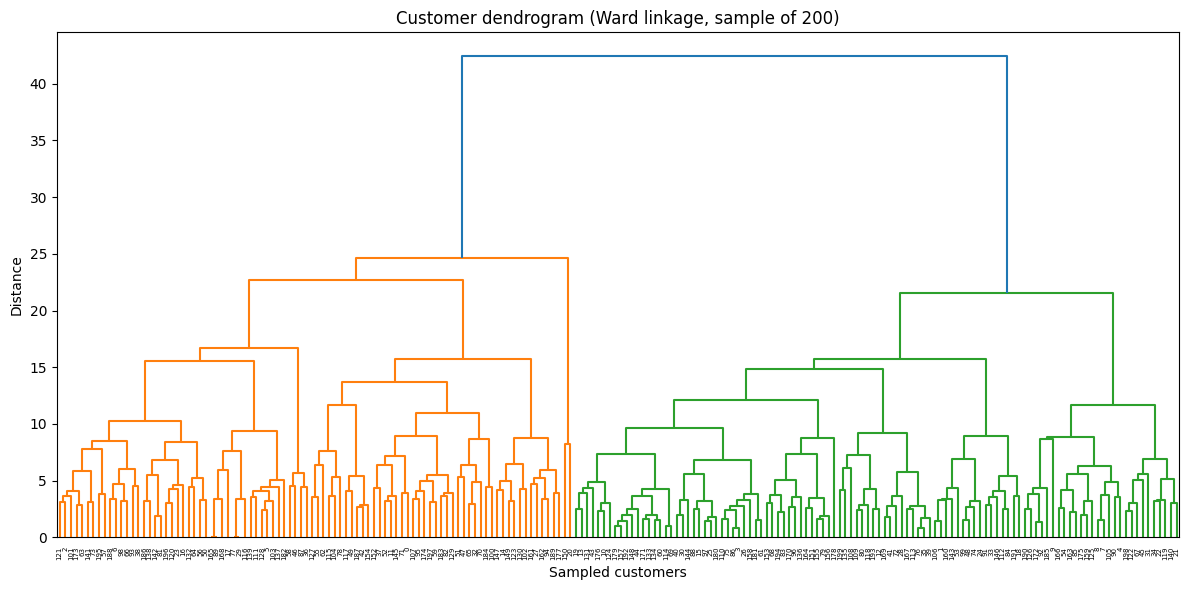

In [27]:
# Using a subset so the dendogram is readable

sample_size = 200
X_sample = X_scaled[:sample_size, :]

linked = linkage(X_sample, method="ward")

plt.figure(figsize=(12, 6))
dendrogram(
    linked,
    orientation="top",
    distance_sort="descending",
    show_leaf_counts=False
)
plt.title("Customer dendrogram (Ward linkage, sample of 200)")
plt.xlabel("Sampled customers")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

**Observation**:  
The dendrogram suggests a few natural splits in the 3–6 cluster range.
This will be used when choosing k for KMeans and Agglomerative.

### **KMeans (Elbow and Silhoutee)**

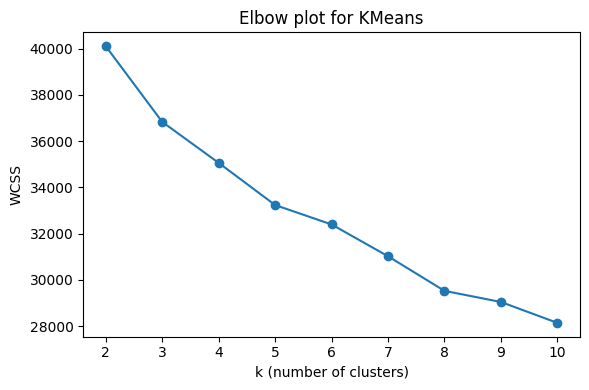

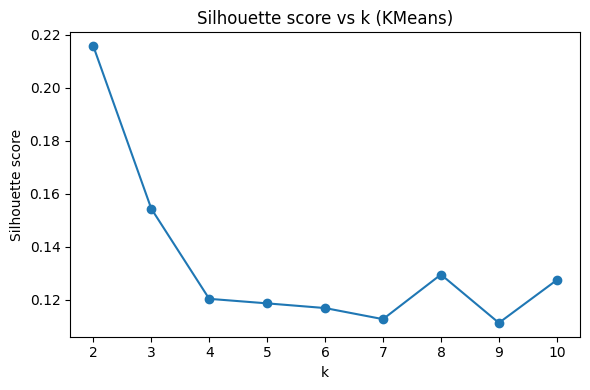

In [28]:
wcss = []
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=10,
        max_iter=300,
        random_state=42
    )
    labels = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Elbow plot
plt.figure(figsize=(6, 4))
plt.plot(k_range, wcss, marker="o")
plt.title("Elbow plot for KMeans")
plt.xlabel("k (number of clusters)")
plt.ylabel("WCSS")
plt.tight_layout()
plt.show()

# Silhouette vs k
plt.figure(figsize=(6, 4))
plt.plot(k_range, sil_scores, marker="o")
plt.title("Silhouette score vs k (KMeans)")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.tight_layout()
plt.show()

**Observation**:  
The elbow + silhouette plots together narrow down a sensible k range (again around 3–6).
This lines up with the dendrogram, which is reassuring.

### **PCA for Visualization and Baseline Clustering**

In [29]:
# Check roughly how much variance is captured by a few PCs

pca_5 = PCA(n_components=5)
X_pca_5 = pca_5.fit_transform(X_scaled)
print("Explained variance ratio (5 components):", pca_5.explained_variance_ratio_)
print("Total variance explained by 5 components:", pca_5.explained_variance_ratio_.sum())

# Reduce to 2 components for plotting

pca_2 = PCA(n_components=2)
X_pca = pca_2.fit_transform(X_scaled)
print("Variance explained by first two PCs:", pca_2.explained_variance_ratio_.sum())

Explained variance ratio (5 components): [0.26559244 0.09265186 0.07712049 0.07392691 0.06330048]
Total variance explained by 5 components: 0.5725921840932631
Variance explained by first two PCs: 0.35824429861661433


**Observation:** A handful of PCs capture a decent chunk of the variance, and the first two are enough to visualise the clusters in 2D. I won’t cluster *on* PCA here; it is being used for plotting.

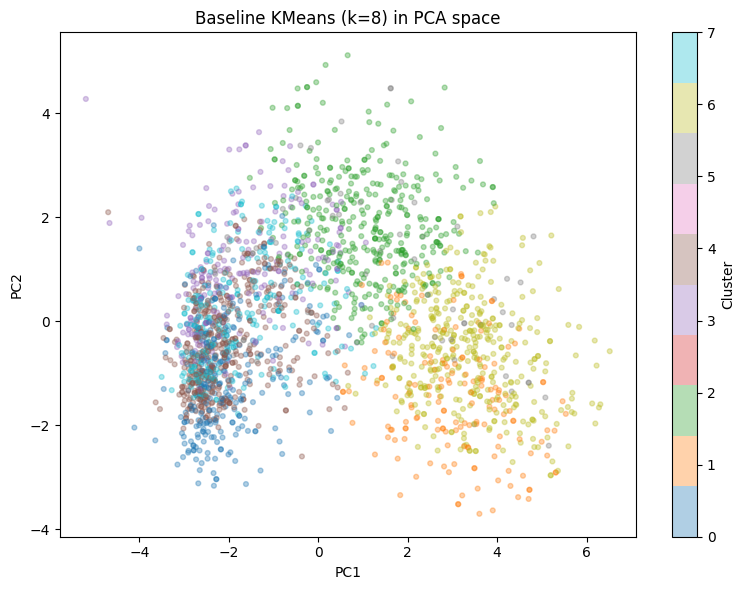

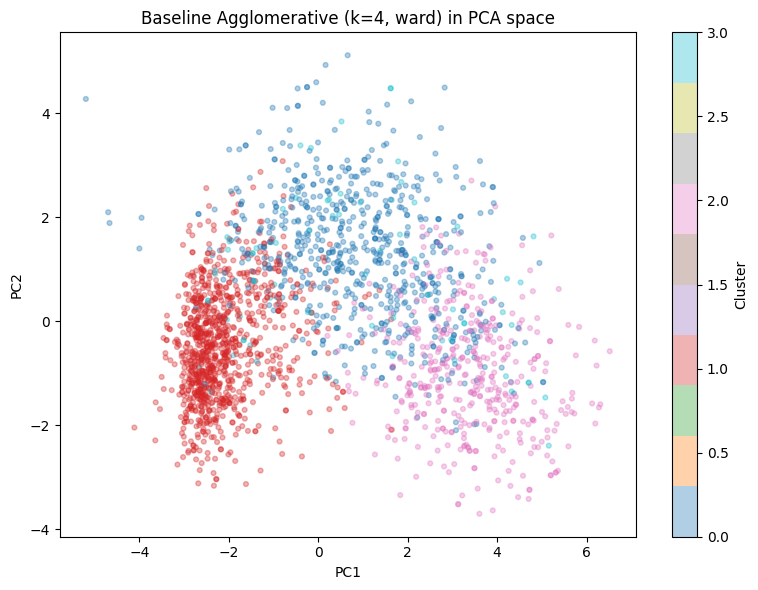

Baseline silhouette (KMeans, k=4): 0.129
Baseline silhouette (Agglomerative, k=4, ward): 0.158


In [30]:
# Baseline KMeans with k=8

initial_kmeans = KMeans(
    n_clusters=8,
    # n_clusters=4,
    init="k-means++",
    n_init=10,
    max_iter=300,
    random_state=42
)

kmeans_labels_initial = initial_kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=kmeans_labels_initial, cmap="tab10", s=12, alpha=0.35)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Baseline KMeans (k=8) in PCA space")
plt.colorbar(label="Cluster")
plt.tight_layout()
plt.show()

# Baseline Agglomerative with k=8, ward linkage

agglo_baseline = AgglomerativeClustering(n_clusters=4, linkage="ward")
agglo_labels_initial = agglo_baseline.fit_predict(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=agglo_labels_initial, cmap="tab10", s=12, alpha=0.35)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Baseline Agglomerative (k=4, ward) in PCA space")
plt.colorbar(label="Cluster")
plt.tight_layout()
plt.show()

baseline_kmeans_sil = silhouette_score(X_scaled, kmeans_labels_initial)
baseline_agglo_sil = silhouette_score(X_scaled, agglo_labels_initial)
print(f"Baseline silhouette (KMeans, k=4): {baseline_kmeans_sil:.3f}")
print(f"Baseline silhouette (Agglomerative, k=4, ward): {baseline_agglo_sil:.3f}")

**Observation**:  
Both algorithms produce reasonably separated blobs in PCA space and decent silhouette scores.
Now I’ll do a slightly more systematic search over k and a few hyperparameters to choose the
final model properly.

### **Hyperparameter Tuning**

**KMeans**

In [31]:
best_kmeans_score = -1
best_kmeans_params = None

for n_clusters in range(3, 7):            # focus on small, interpretable k values
    for init in ["k-means++", "random"]:
        for n_init in [10, 20]:
            for max_iter in [300, 500]:
                kmeans = KMeans(
                    n_clusters=n_clusters,
                    init=init,
                    n_init=n_init,
                    max_iter=max_iter,
                    random_state=42
                )
                labels = kmeans.fit_predict(X_scaled)
                score = silhouette_score(X_scaled, labels)
                print(f"KMeans -> k={n_clusters}, init={init}, n_init={n_init}, "
                      f"max_iter={max_iter}, silhouette={score:.3f}")

                if score > best_kmeans_score:
                    best_kmeans_score = score
                    best_kmeans_params = (n_clusters, init, n_init, max_iter)

print("\nBest KMeans params:")
print(f"k={best_kmeans_params[0]}, init={best_kmeans_params[1]}, "
      f"n_init={best_kmeans_params[2]}, max_iter={best_kmeans_params[3]}")
print(f"Best KMeans silhouette: {best_kmeans_score:.3f}")



KMeans -> k=3, init=k-means++, n_init=10, max_iter=300, silhouette=0.154
KMeans -> k=3, init=k-means++, n_init=10, max_iter=500, silhouette=0.154
KMeans -> k=3, init=k-means++, n_init=20, max_iter=300, silhouette=0.154
KMeans -> k=3, init=k-means++, n_init=20, max_iter=500, silhouette=0.154
KMeans -> k=3, init=random, n_init=10, max_iter=300, silhouette=0.154
KMeans -> k=3, init=random, n_init=10, max_iter=500, silhouette=0.154
KMeans -> k=3, init=random, n_init=20, max_iter=300, silhouette=0.154
KMeans -> k=3, init=random, n_init=20, max_iter=500, silhouette=0.154
KMeans -> k=4, init=k-means++, n_init=10, max_iter=300, silhouette=0.120
KMeans -> k=4, init=k-means++, n_init=10, max_iter=500, silhouette=0.120
KMeans -> k=4, init=k-means++, n_init=20, max_iter=300, silhouette=0.159
KMeans -> k=4, init=k-means++, n_init=20, max_iter=500, silhouette=0.159
KMeans -> k=4, init=random, n_init=10, max_iter=300, silhouette=0.159
KMeans -> k=4, init=random, n_init=10, max_iter=500, silhouette=0.

**Observation**:  
This mini grid search gives me a concrete “best” KMeans setup instead of just eyeballing k.
The silhouette score acts as a quantitative measure of how well-separated the clusters are.

In [32]:
best_k, best_init, best_n_init, best_max_iter = best_kmeans_params

final_kmeans = KMeans(
    n_clusters=best_k,
    init=best_init,
    n_init=best_n_init,
    max_iter=best_max_iter,
    random_state=42
)
kmeans_labels_final = final_kmeans.fit_predict(X_scaled)
data["Cluster_KMeans"] = kmeans_labels_final

In [33]:
print("First 5 rows with KMeans cluster assignments:")
display(data[['ID', 'Age', 'Income', 'Cluster_KMeans']].head())

print("\nCounts of customers per KMeans cluster:")
display(data['Cluster_KMeans'].value_counts().sort_index())

First 5 rows with KMeans cluster assignments:


,ID,Age,Income,Cluster_KMeans
0,5524,68,58138.0,2
1,2174,71,46344.0,1
2,4141,60,71613.0,2
3,6182,41,26646.0,1
4,5324,44,58293.0,3



Counts of customers per KMeans cluster:


,count
Cluster_KMeans,
0,76
1,972
2,562
3,599


In [34]:
from collections import Counter

best_agglo_score = -1
best_agglo_params = None

param_grid_agglo = {
    "n_clusters": range(3, 7),
    "linkage": ["ward", "complete", "average", "single"]
}

for n_clusters in param_grid_agglo["n_clusters"]:
    for linkage_method in param_grid_agglo["linkage"]:
        try:
            agglo = AgglomerativeClustering(
                n_clusters=n_clusters,
                linkage=linkage_method
            )

            labels = agglo.fit_predict(X_scaled)

            # Count cluster sizes
            counts = Counter(labels)

            # Skip unrealistic solutions (e.g., clusters < 30 customers)
            if min(counts.values()) < 30:
                print(f" Skipped k={n_clusters}, linkage={linkage_method} "
                      f"due to tiny cluster sizes: {counts}")
                continue

            score = silhouette_score(X_scaled, labels)
            print(f"Agglomerative -> k={n_clusters}, linkage={linkage_method}, "
                  f"silhouette={score:.3f}")

            if score > best_agglo_score:
                best_agglo_score = score
                best_agglo_params = (n_clusters, linkage_method)

        except Exception as e:
            print(f"Error for k={n_clusters}, linkage={linkage_method}: {e}")

print("\nBest Agglomerative params:")
print(f"k={best_agglo_params[0]}, linkage={best_agglo_params[1]}")
print(f"Best realistic Agglomerative silhouette: {best_agglo_score:.3f}")


Agglomerative -> k=3, linkage=ward, silhouette=0.153
 Skipped k=3, linkage=complete due to tiny cluster sizes: Counter({np.int64(0): 2204, np.int64(2): 4, np.int64(1): 1})
 Skipped k=3, linkage=average due to tiny cluster sizes: Counter({np.int64(0): 2204, np.int64(2): 4, np.int64(1): 1})
 Skipped k=3, linkage=single due to tiny cluster sizes: Counter({np.int64(0): 2207, np.int64(2): 1, np.int64(1): 1})
Agglomerative -> k=4, linkage=ward, silhouette=0.158
 Skipped k=4, linkage=complete due to tiny cluster sizes: Counter({np.int64(0): 2195, np.int64(1): 9, np.int64(2): 4, np.int64(3): 1})
 Skipped k=4, linkage=average due to tiny cluster sizes: Counter({np.int64(1): 2201, np.int64(2): 4, np.int64(0): 3, np.int64(3): 1})
 Skipped k=4, linkage=single due to tiny cluster sizes: Counter({np.int64(1): 2203, np.int64(0): 4, np.int64(2): 1, np.int64(3): 1})
Agglomerative -> k=5, linkage=ward, silhouette=0.152
 Skipped k=5, linkage=complete due to tiny cluster sizes: Counter({np.int64(0): 2192,

**Observation**:  
Agglomerative clustering is quite sensitive to the linkage choice and to very unbalanced cluster sizes. By skipping any solution where a cluster has fewer than 30 customers and scanning several linkages for k=3–6, I end up with a realistic best model at k=4, linkage=ward (silhouette ≈ 0.158). This gives a fair comparison against the tuned KMeans model.

In [35]:
# Fit the final Agglomerative model using the best realistic parameters
best_agglo_k, best_agglo_linkage = best_agglo_params

final_agglo = AgglomerativeClustering(
    n_clusters=best_agglo_k,
    linkage=best_agglo_linkage
)

# Assign final cluster labels to the dataset
data["Final_Cluster"] = final_agglo.fit_predict(X_scaled)

print("Final clusters assigned using:")
print(f"k = {best_agglo_k}, linkage = {best_agglo_linkage}")

Final clusters assigned using:
k = 4, linkage = ward


In [36]:
Counter(data["Final_Cluster"])

Counter({2: 442, 1: 1018, 0: 673, 3: 76})

In [37]:
cluster_profile_numeric = data.groupby("Final_Cluster")[features].mean()
cluster_profile_numeric


,Age,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Tenure,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Married,Marital_Status_Single,Marital_Status_Widow
Final_Cluster,,,,,,,,,,,,,,,,,,,,,
0,59.687964,60413.106984,0.215453,0.772660,48.484398,519.777117,25.744428,188.671620,36.667162,27.283804,...,3.647845,7.603269,5.438336,4555.352155,0.369985,0.248143,0.378900,0.719168,0.163447,0.0
1,53.473477,35889.850688,0.767191,0.453831,49.486248,48.428291,5.573674,26.110020,8.110020,5.510806,...,0.590373,3.390963,6.267191,4466.548134,0.493124,0.265226,0.191552,0.653242,0.240668,0.0
2,55.416290,76743.122172,0.072398,0.192308,49.079186,559.190045,74.199095,456.149321,104.608597,74.565611,...,5.866516,8.520362,3.018100,4516.841629,0.742081,0.248869,0.009050,0.635747,0.262443,0.0
3,66.236842,56481.552632,0.236842,0.644737,48.802632,367.131579,31.868421,185.328947,49.907895,37.868421,...,3.302632,6.355263,4.934211,4519.723684,0.460526,0.210526,0.315789,0.000000,0.000000,1.0


**Observation**: **Cluster Profiles (Interpretation)**

The Agglomerative Clustering model (k=4, ward) produced four distinct and interpretable customer segments:

- Cluster 1 – Value Seekers / Low-Engagement Browsers
This is the largest group (n=1018). Customers have the lowest income and spend very little across all product categories. They visit the website frequently but do not convert into high spend, indicating low engagement or high price sensitivity.

- Cluster 0 – Wine-Focused Steady Shoppers
These customers have mid-high income and exhibit consistently high spending on wine and meat products. They prefer in-store purchases, suggesting they are loyal and steady physical shoppers.

- Cluster 2 – Premium High-Value Customers
This is the most profitable group. They have the highest income and spend heavily across all categories (wine, fruits, meat, fish, sweets). They shop through multiple channels and show strong purchasing power. This is an important target segment for premium-priced campaigns.

- Cluster 3 – Moderate Traditional In-Store Buyers
A smaller (but not tiny) group with mid-high income. Their spending is moderate, leaning towards wine and meat products. They shop mostly in-store and show relatively stable but not aggressive purchase behaviour.

**Reflection on the cluster approach**

While the final Agglomerative model (k=4, ward) produced meaningful and usable customer segments, I think it’s important to recognise a few limitations in the approach. The silhouette score (≈0.16) suggests that the clusters are only moderately separated, which is pretty normal for behavioural marketing data but also means some customers may sit close to the boundaries between groups. As I was analysing the results, I realised that different choices such as including or excluding certain features, changing the distance metrics, or even applying a different scaling method could lead to slightly different cluster shapes.

I also assumed that customer behaviour is relatively stable, but in a real business environment spending patterns can shift over time, so the model would need to be reviewed or retrained periodically. Another point I considered is that all features were weighted equally, even though some behaviours (e.g., total spending or web engagement) might be more influential than others. Using alternative methods like Gaussian Mixture Models or HDBSCAN could be useful in future work to test the stability and robustness of the segmentation.

These limitations don’t undermine the usefulness of the results, but they highlight areas I would refine or explore further if I were developing this model for a real organisation.

In [38]:
data.groupby("Final_Cluster")["Response"].mean()


,Response
Final_Cluster,
0,0.184250
1,0.079568
2,0.242081
3,0.236842


**Observation: Campaign Response Patterns**

The four clusters exhibit clear differences in how they respond to past promotional campaigns:

• Cluster 2 has the highest campaign response rate (appr. 24%), confirming that the premium, high-spend segment is also the most likely to accept new offers.
• Cluster 3 also responds well (appr. 24%), despite being smaller and more traditional in-store shoppers.
• Cluster 0 has a moderate response rate (appr. 18%), while Cluster 1 has the lowest (appr. 8%), suggesting that low-income / low-spend customers are difficult to convert via standard campaigns.

### **Visual Comparison (Tuned KMeans and Agglomerative)**

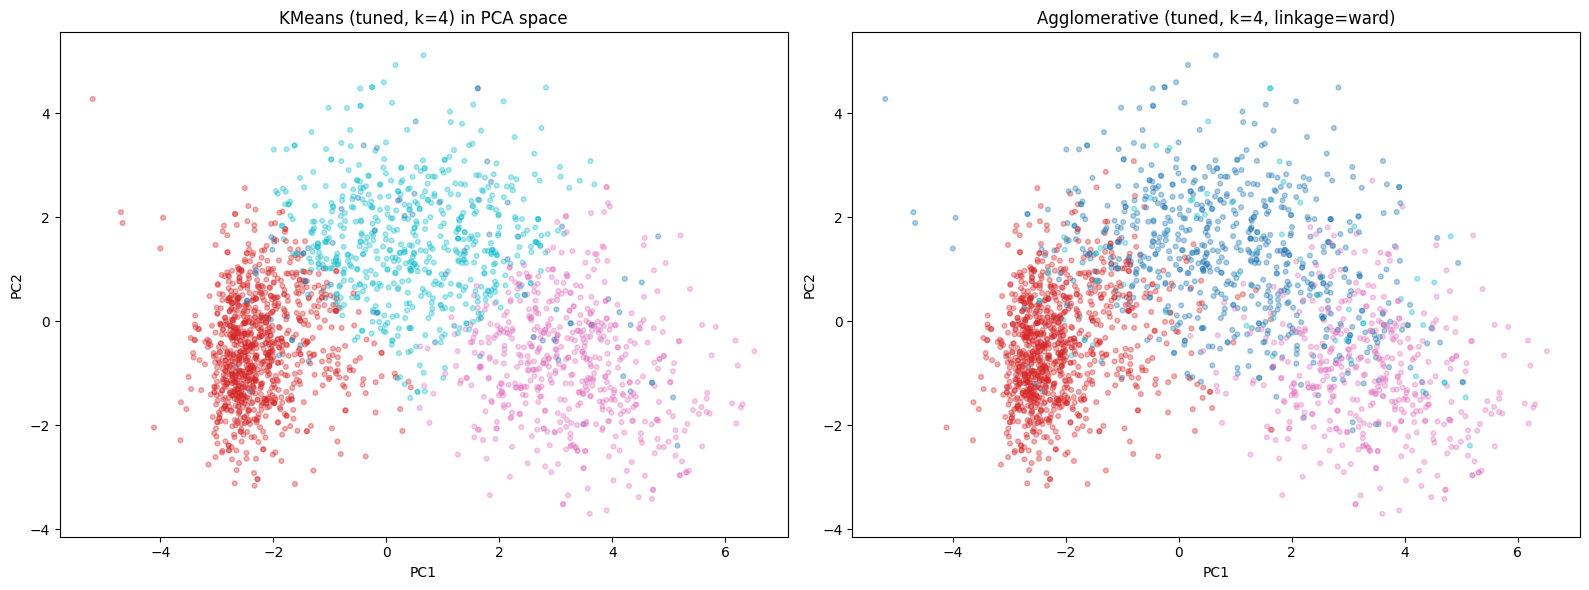

Tuned silhouette (KMeans): 0.159
Tuned silhouette (Agglomerative): 0.158


In [39]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(X_pca[:, 0], X_pca[:, 1],
                c=data["Cluster_KMeans"].astype(int), cmap="tab10", s=12, alpha=0.35)
axes[0].set_title(f"KMeans (tuned, k={best_k}) in PCA space")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

axes[1].scatter(X_pca[:, 0], X_pca[:, 1],
                c=data["Final_Cluster"].astype(int), cmap="tab10", s=12, alpha=0.35)
axes[1].set_title(f"Agglomerative (tuned, k={best_agglo_k}, linkage={best_agglo_linkage})")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()

kmeans_silhouette = silhouette_score(X_scaled, data["Cluster_KMeans"])
agglo_silhouette = silhouette_score(X_scaled, data["Final_Cluster"])
print(f"Tuned silhouette (KMeans): {kmeans_silhouette:.3f}")
print(f"Tuned silhouette (Agglomerative): {agglo_silhouette:.3f}")

**Observation**:  
Both tuned models have very similar silhouette scores (≈0.16), which is modest but not unusual for messy customer data. Visually, the Agglomerative clusters look slightly more compact in PCA space, so I choose the Agglomerative (k=4, ward) model as my final segmentation, while acknowledging that the separation is moderate rather than perfect.

**PCA Plots for Report (KMEANS VS AGGLOMERATIVE)**

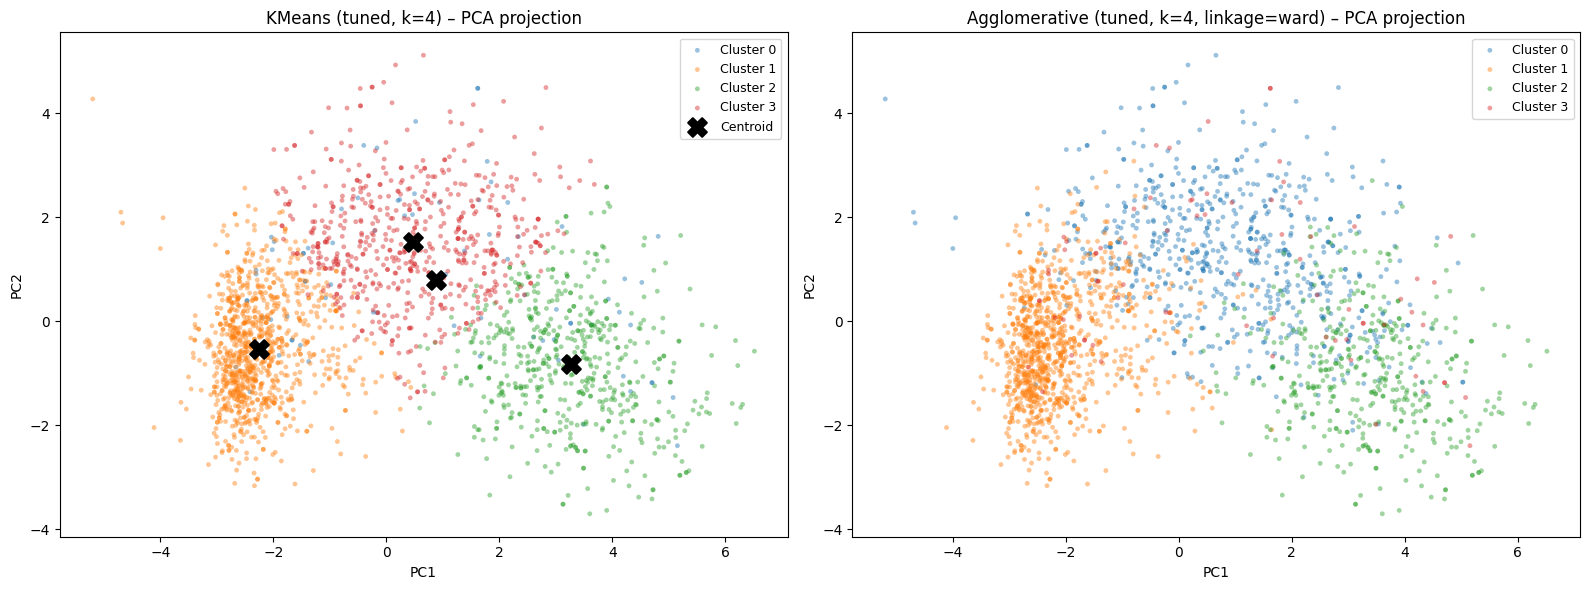

Tuned silhouette (KMeans):        0.159
Tuned silhouette (Agglomerative): 0.158


In [40]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

unique_kmeans_clusters = np.sort(data["Cluster_KMeans"].unique())
palette_kmeans = sns.color_palette("tab10", len(unique_kmeans_clusters))

for idx, cl in enumerate(unique_kmeans_clusters):
    mask = data["Cluster_KMeans"] == cl
    axes[0].scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        s=12,
        alpha=0.45,
        color=palette_kmeans[idx],
        edgecolors="none",
        label=f"Cluster {cl}",
    )

# overlay KMeans centroids in PCA space (big X markers)
kmeans_centroids_pca = pca_2.transform(final_kmeans.cluster_centers_)


axes[0].scatter(
    kmeans_centroids_pca[:, 0],
    kmeans_centroids_pca[:, 1],
    s=180,
    marker="X",
    color="black",
    linewidths=1.5,
    label="Centroid",
)

axes[0].set_title(f"KMeans (tuned, k={best_k}) – PCA projection", fontsize=12)
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].legend(frameon=True, fontsize=9, loc="best")

# -----------------------------------------------------------
# 2) Agglomerative plot – one colour per cluster
# -----------------------------------------------------------
unique_agglo_clusters = np.sort(data["Final_Cluster"].unique())
palette_agglo = sns.color_palette("tab10", len(unique_agglo_clusters))

for idx, cl in enumerate(unique_agglo_clusters):
    mask = data["Final_Cluster"] == cl
    axes[1].scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        s=12,
        alpha=0.45,
        color=palette_agglo[idx],
        edgecolors="none",
        label=f"Cluster {cl}",
    )

axes[1].set_title(
    f"Agglomerative (tuned, k={best_agglo_k}, linkage={best_agglo_linkage}) – PCA projection",
    fontsize=12
)
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].legend(frameon=True, fontsize=9, loc="best")

plt.tight_layout()
plt.show()

# recompute / print silhouettes right under the figure
kmeans_silhouette = silhouette_score(X_scaled, data["Cluster_KMeans"])
agglo_silhouette = silhouette_score(X_scaled, data["Final_Cluster"])
print(f"Tuned silhouette (KMeans):        {kmeans_silhouette:.3f}")
print(f"Tuned silhouette (Agglomerative): {agglo_silhouette:.3f}")

### **Final Model Choice**

Final chosen clustering model:
Agglomerative (k=4, linkage=ward)

Cluster sizes:
Counter({1: 1018, 0: 673, 2: 442, 3: 76})


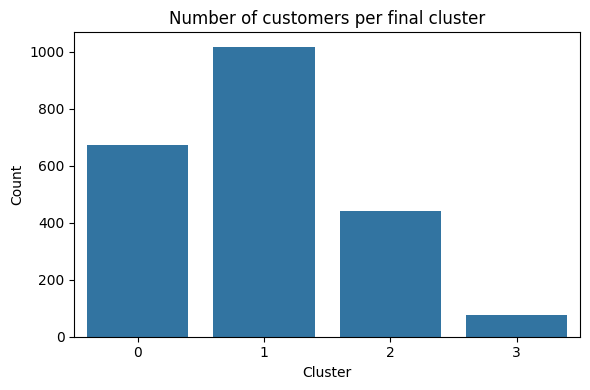


Cluster profiles – mean feature values:


,Age,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Tenure,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Married,Marital_Status_Single,Marital_Status_Widow
Final_Cluster,,,,,,,,,,,,,,,,,,,,,
0,59.687964,60413.106984,0.215453,0.772660,48.484398,519.777117,25.744428,188.671620,36.667162,27.283804,...,3.647845,7.603269,5.438336,4555.352155,0.369985,0.248143,0.378900,0.719168,0.163447,0.0
1,53.473477,35889.850688,0.767191,0.453831,49.486248,48.428291,5.573674,26.110020,8.110020,5.510806,...,0.590373,3.390963,6.267191,4466.548134,0.493124,0.265226,0.191552,0.653242,0.240668,0.0
2,55.416290,76743.122172,0.072398,0.192308,49.079186,559.190045,74.199095,456.149321,104.608597,74.565611,...,5.866516,8.520362,3.018100,4516.841629,0.742081,0.248869,0.009050,0.635747,0.262443,0.0
3,66.236842,56481.552632,0.236842,0.644737,48.802632,367.131579,31.868421,185.328947,49.907895,37.868421,...,3.302632,6.355263,4.934211,4519.723684,0.460526,0.210526,0.315789,0.000000,0.000000,1.0


In [41]:
print("Final chosen clustering model:")
print(f"Agglomerative (k={best_agglo_k}, linkage={best_agglo_linkage})")

# Cluster Sizes

from collections import Counter
cluster_counts = Counter(data["Final_Cluster"])

print("\nCluster sizes:")
print(cluster_counts)

# Bar Chart
plt.figure(figsize=(6,4))
sns.barplot(x=list(cluster_counts.keys()), y=list(cluster_counts.values()))
plt.title("Number of customers per final cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# Cluster Profiles

cluster_profile_numeric = data.groupby("Final_Cluster")[features].mean()
print("\nCluster profiles – mean feature values:")
display(cluster_profile_numeric)


**Observation**:  
The four clusters are quite different in both size and behaviour:

- Cluster 1 (n=1018) has the lowest average income and spending across almost all categories. These customers still visit the website fairly often but do not convert into high spend. This looks like a large, low-value, price-sensitive segment.

- Cluster 0 (n=673) has mid–high income and very strong wine and meat spending, with relatively frequent store purchases. This group behaves like steady, wine-focused shoppers who are already reasonably engaged.

- Cluster 2 (n=442) shows the highest income and the highest spend across all product categories (wine, meat, fish, sweets, etc.), as well as active use of catalogue and store channels. This is clearly the premium high-value segment.

- Cluster 3 (n=76) is a smaller group with moderate income and moderate spend, leaning more towards in-store shopping than online. They are less valuable than Cluster 2 but still more engaged than the low-spend Cluster 1.

These profiles confirm that the clustering has separated customers into meaningful segments that differ in income level, product mix, and channel usage, which can be used to design targeted marketing strategies.

In [42]:
# Standardised cluster profiles (z-scores) to highlight "top" features per cluster

feature_means = data[features].mean()
feature_stds = data[features].std()

cluster_means = data.groupby("Final_Cluster")[features].mean()
cluster_zscores = (cluster_means - feature_means) / feature_stds

print("\nCluster profiles – standardised (z-scores):")
display(cluster_zscores.round(2))



Cluster profiles – standardised (z-scores):


,Age,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Tenure,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Married,Marital_Status_Single,Marital_Status_Widow
Final_Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.29,0.32,-0.42,0.49,-0.02,0.64,-0.02,0.10,-0.02,0.01,...,0.33,0.55,0.05,0.25,-0.27,-0.02,0.39,0.15,-0.12,-0.19
1,-0.23,-0.65,0.61,-0.09,0.01,-0.76,-0.52,-0.63,-0.54,-0.52,...,-0.71,-0.74,0.39,-0.19,-0.02,0.02,-0.06,0.01,0.07,-0.19
2,-0.06,0.97,-0.69,-0.57,0.00,0.75,1.20,1.29,1.23,1.16,...,1.09,0.84,-0.95,0.06,0.48,-0.01,-0.50,-0.02,0.12,-0.19
3,0.84,0.17,-0.38,0.26,-0.01,0.18,0.14,0.08,0.23,0.26,...,0.22,0.17,-0.16,0.07,-0.09,-0.10,0.24,-1.35,-0.52,5.30


In [43]:
# For each cluster, show top 5 features that are highest above the overall mean
top_n = 5
for cl in cluster_zscores.index:
    print(f"\nTop {top_n} distinguishing features for cluster {cl}:")
    print(cluster_zscores.loc[cl].sort_values(ascending=False).head(top_n))



Top 5 distinguishing features for cluster 0:
NumWebPurchases      0.731212
MntWines             0.635446
NumStorePurchases    0.553262
NumDealsPurchases    0.552995
Teenhome             0.491356
Name: 0, dtype: float64

Top 5 distinguishing features for cluster 1:
Kidhome                  0.605861
NumWebVisitsMonth        0.391234
Marital_Status_Single    0.067003
Education_Master         0.023767
Recency                  0.014170
Name: 1, dtype: float64

Top 5 distinguishing features for cluster 2:
MntMeatProducts        1.287616
MntFishProducts        1.228419
MntFruits              1.202111
MntSweetProducts       1.155123
NumCatalogPurchases    1.092379
Name: 2, dtype: float64

Top 5 distinguishing features for cluster 3:
Marital_Status_Widow    5.296516
Age                     0.838196
MntSweetProducts        0.262536
Teenhome                0.256341
Education_PhD           0.241340
Name: 3, dtype: float64


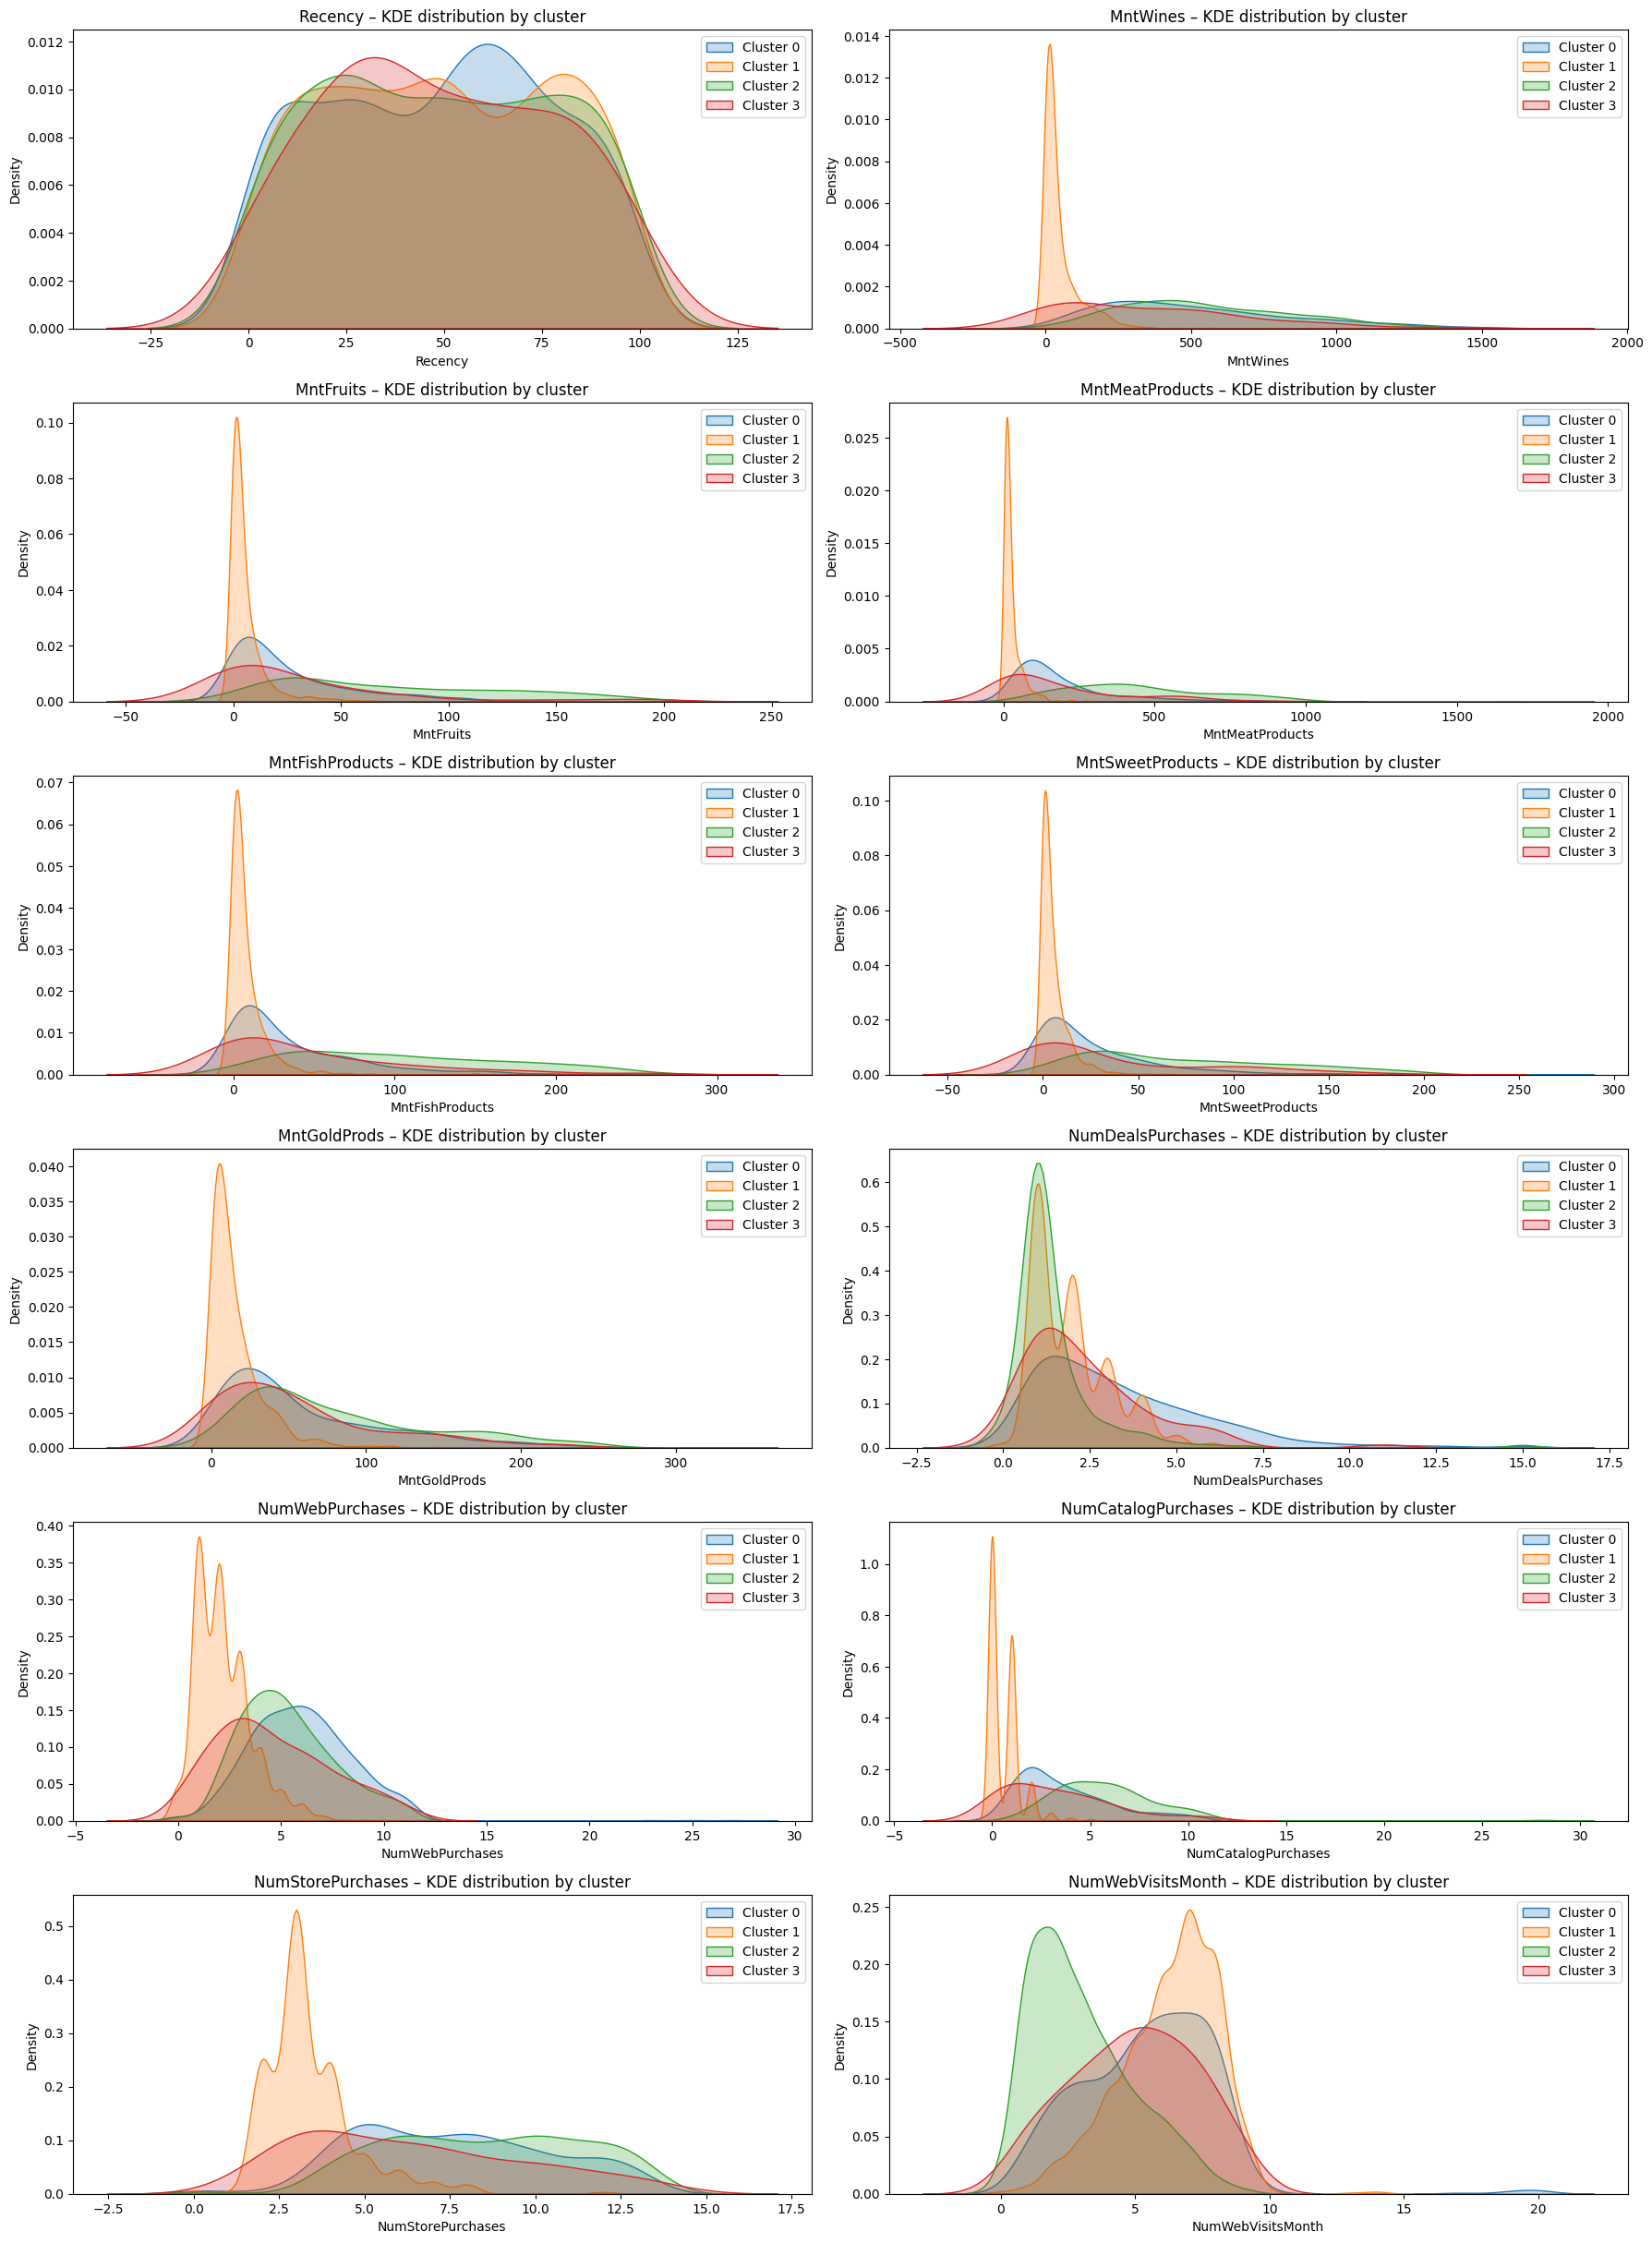

In [44]:

behaviour_features = [
    'Recency',
    'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
    'MntSweetProducts', 'MntGoldProds',
    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
    'NumStorePurchases', 'NumWebVisitsMonth'
]


plt.figure(figsize=(18, 28))

for i, col in enumerate(behaviour_features, 1):
    plt.subplot(len(behaviour_features)//2 + 1, 2, i)
    for cl in sorted(data['Final_Cluster'].unique()):
        sns.kdeplot(
            data[data['Final_Cluster'] == cl][col],
            label=f"Cluster {cl}",
            fill=True,
            alpha=0.25
        )
    plt.title(f"{col} – KDE distribution by cluster")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()

plt.tight_layout()
plt.show()


### **Linking Clusters to Campaign Response**


Average Response rate per cluster (sorted):
Final_Cluster
2    0.242081
3    0.236842
0    0.184250
1    0.079568
Name: Response, dtype: float64


,CustomerCount,MeanResponse
Final_Cluster,,
2,442,0.242081
3,76,0.236842
0,673,0.184250
1,1018,0.079568


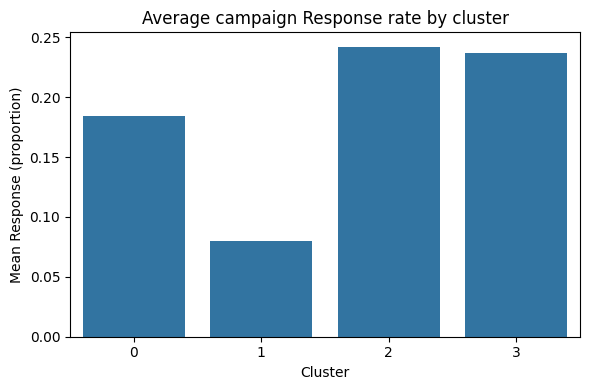

In [45]:
# This is the key bit: which clusters actually respond better to campaigns?

if "Response" in data.columns:
    response_by_cluster = data.groupby("Final_Cluster")["Response"].mean().sort_values(ascending=False)
    count_by_cluster = data.groupby("Final_Cluster")["Response"].count()

    print("\nAverage Response rate per cluster (sorted):")
    print(response_by_cluster)

    response_summary = pd.DataFrame({
        "CustomerCount": count_by_cluster,
        "MeanResponse": data.groupby("Final_Cluster")["Response"].mean()
    })
    display(response_summary.sort_values("MeanResponse", ascending=False))

    plt.figure(figsize=(6, 4))
    sns.barplot(x=response_summary.index, y=response_summary["MeanResponse"])
    plt.title("Average campaign Response rate by cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Mean Response (proportion)")
    plt.tight_layout()
    plt.show()

**Observation**

- The cluster with the highest MeanResponse is the most campaign-responsive group.

- That segment would be my main target for future promotional campaigns.

- Clusters with moderate response but high income or high total spend are strong candidates for upselling.

- Very low-response clusters are not ideal for short-term conversion campaigns, but they can still be useful for broader awareness or long-term engagement strategies.

If `Response` data were not available, I could still target segments based on spending and engagement behaviour (e.g., focusing on high-value clusters), but I would lose the direct link to past campaign success.

### **Final Conclusion**

The clustering analysis allowed me to identify four clear and practical customer segments using the Agglomerative model (k=4, ward). Even though the silhouette score is only moderate, the groups still make sense when compared with real customer behaviour, and each segment shows its own distinct pattern.

When I reviewed the cluster profiles, I could clearly see differences in income levels, spending behaviour, preferred shopping channels, and interest in different product categories. These patterns give the business a solid starting point for designing more targeted marketing actions, such as personalised campaigns, loyalty rewards, and cross-selling opportunities.

The analysis also revealed a particularly valuable premium group (Cluster 2), a reliable mid-income wine-and-meat segment (Cluster 0), a large price-sensitive browsing group (Cluster 1), and a smaller, more traditional in-store customer base (Cluster 3). Knowing how these groups differ means the business can allocate its marketing budget more intelligently, focusing on high-value customers while still keeping low-spend customers engaged in a cost-effective way.

Overall, this segmentation provides a useful blueprint for understanding the customer base and shaping more efficient marketing decisions. It helps the company match its offers and communication more closely to what different customer groups genuinely need and value.